In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mgo
from torch_helper import torch_func
from scipy.optimize import brentq

In [2]:
data = np.load('./epoch_data/epoch_trapped_UH.npz')
t_full, x_full, E_full = data['t'], data['x'], data['E']
print(list(data.keys()))

['t', 'x', 'E', 'n_e', 'T_e', 'source_freq', 'source_t_profile', 'B0']


In [3]:
for key in ['n_e', 'T_e', 'source_freq', 'source_t_profile', 'B0']:
    print(key, data[key])

n_e 0.255e19*exp(-(x/0.008)^2)
T_e 100
source_freq 140e9
source_t_profile 2/pi*atan(time*5e9) * (1/pi * atan(-(time - 15e-9) * 5e9) + 0.5)
B0 2.4


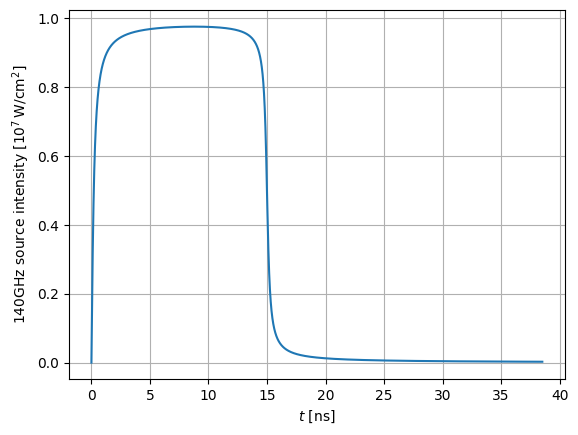

In [4]:
source_t_profile = lambda t: 2/np.pi*np.arctan(t*5e9) * (1/np.pi * np.arctan(-(t - 15e-9) * 5e9) + 0.5)
plt.plot(t_full*1e9, source_t_profile(t_full))
plt.grid()
plt.xlabel(r'$t$ [ns]')
plt.ylabel(r'140GHz source intensity [$10^7 \, \mathrm{W/{cm}^2}$]')
plt.show()

In [5]:
import torch
from scipy.constants import e, m_e, epsilon_0, c

# Constants
n0 = 0.255e19
T0 = 100*e
f0 = 140e9
omega0 = 2*np.pi*f0
L_ne = 8e-3
B0 = 2.4

@torch_func
def B(x: ('scalar')):
    return B0 * torch.ones_like(x)

@torch_func
def omega_c(x: ('scalar')):
    return e*B(x)/m_e

@torch_func
def T_e(x: ('scalar')):
    return T0

@torch_func
def n_e(x: ('scalar')):
    return n0 * torch.exp(-(x/L_ne)**2)

@torch_func
def omega_p_squared(x: ('scalar')):
    return n_e(x) * e**2 / (epsilon_0 * m_e)

@torch_func
def v_Te_squared(x: ('scalar')):
    return 2*T_e(x)/m_e

@torch_func
def Stix_S(x: ('scalar'), omega: ('scalar')):
    return 1 - (omega_p_squared(x)/(omega**2 - (omega_c(x)**2 )))

@torch_func
def Stix_D(x: ('scalar'), omega: ('scalar')):
    return (omega_c(x)/omega) * (omega_p_squared(x)/(omega**2 - (omega_c(x)**2)))

@torch_func
def lamb(x: ('scalar'), k: ('scalar')):
    return v_Te_squared(x)/(2 * (omega_c(x)**2)) * (torch.abs(k)**2)

@torch_func
def Omega(x: ('scalar'), omega: ('scalar')):
    return omega/omega_c(x)

@torch_func
def K1_int(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    _psi = torch.linspace(0, torch.pi, 100)
    return (torch.exp(-lamb(x, k))
            * torch.trapezoid(
            (torch.sin(torch.outer(_psi, Omega(x, omega).reshape(-1)))
                * torch.outer(torch.sin(_psi), torch.ones_like(x.reshape(-1)))
                * torch.exp(
                    - torch.outer(torch.cos(_psi), lamb(x, k).reshape(-1))
                    )
            ), _psi, dim=0)
            )

@torch_func
def K1(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    return ((torch.sin(torch.pi * Omega(x, omega)))
     + (omega_p_squared(x)/(omega_c(x)**2))
        * (K1_int(x, k, omega))
    )

@torch_func
def D(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    return ((c/omega)**2 *
            (K1(x, k, omega) * (torch.abs(k)**2)
             - (torch.sin(torch.pi * Omega(x, omega)))*(omega/c)**2 *
             (Stix_S(x, omega)**2 - Stix_D(x, omega)**2)))

def D_vec(x, k, omega):
    return D(x.flatten(), k.flatten(), omega.flatten()).reshape(x.shape)

def get_k0(x0, omega0, kmin, kmax):
    return brentq(lambda k: D(x0, k, omega0), kmin, kmax)

### Investigate Dispersion Relation

#### Test Dispersion on a $(x, k, \omega)$ point

In [14]:
k0 = 10e3
f0 = f0
omega0 = 2*np.pi*f0
x0 = 0

print(
    'B', B(x0),
    '\n omega_c', omega_c(x0),
    '\n n_e', n_e(x0),
    '\n omega_p_squared', omega_p_squared(x0),
    '\n Stix_S', Stix_S(x0, omega0),
    '\n Stix_D', Stix_D(x0, omega0),
    '\n lambd', lamb(x0, k0),
    '\n v_Te_squared', v_Te_squared(x0),
    '\n K1_int', K1_int(x0, k0, omega0),
    '\n K1', K1(x0, k0, omega0),
    '\n D', D(x0, k0, omega0)
)

B tensor(2.4000) 
 omega_c tensor(4.2212e+11) 
 n_e tensor(2.5500e+18) 
 omega_p_squared tensor(8.1154e+21) 
 Stix_S tensor(0.9864) 
 Stix_D tensor(0.0065) 
 lambd tensor(0.0099) 
 v_Te_squared 35176400215443.266 
 K1_int tensor([-0.0846]) 
 K1 tensor([0.2567]) 
 D tensor([2.7277])


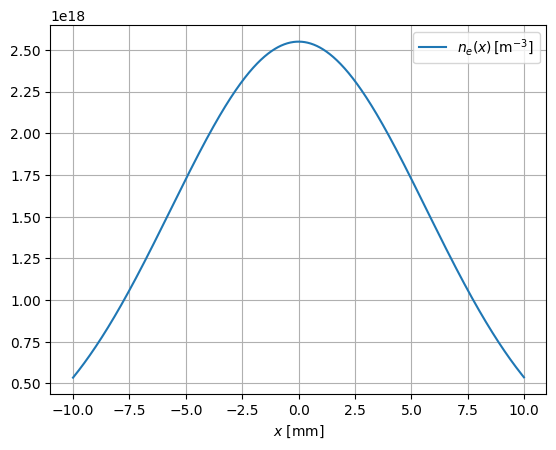

In [15]:
plt.plot(x_full*1e3, n_e(x_full), label=r'$n_e(x) \, \mathrm{[m^{-3}]}$')
plt.xlabel(r'$x$ [mm]')
plt.legend()
plt.grid()
plt.show()

In [16]:
omega_c(x_full)**2 + omega_p_squared(x_full)

tensor([1.7988e+23, 1.7989e+23, 1.7990e+23,  ..., 1.7990e+23, 1.7990e+23,
        1.7989e+23])

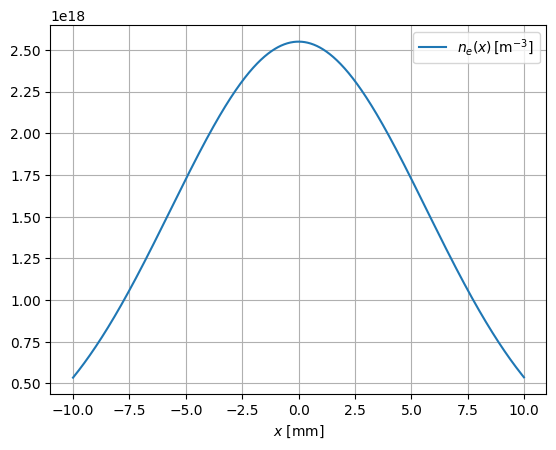

In [17]:
plt.plot(x_full*1e3, n_e(x_full), label=r'$n_e(x) \, \mathrm{[m^{-3}]}$')
plt.xlabel(r'$x$ [mm]')
plt.legend()
plt.grid()
plt.show()

In [18]:
from numpy.fft import fft, fftfreq

tmin, tmax = 15e-9, 30e-9
where_t = np.where((t_full >= tmin) & (t_full <= tmax))
where_x = np.argmin(np.abs(x_full - x0))
E_spec = fft(E_full[where_t, where_x].squeeze())
freq = fftfreq(t_full[where_t].shape[-1], d = t_full[where_t][1] - t_full[where_t][0])

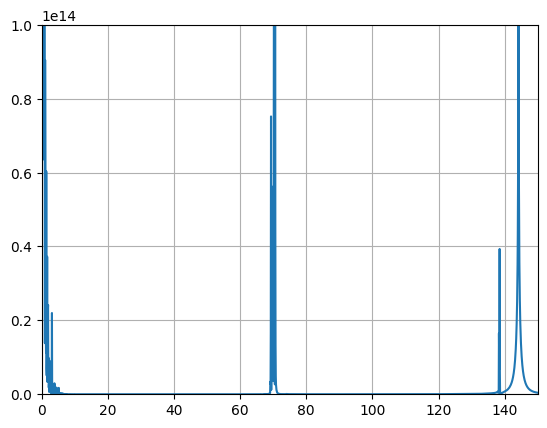

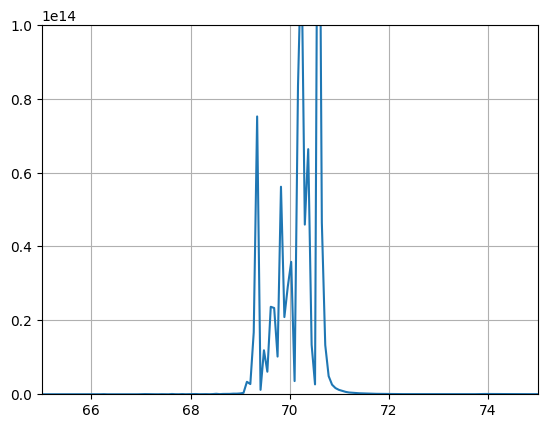

In [19]:
# plt.plot(freq, E_spec.real, freq, E_spec.imag)
plt.plot(freq[freq>=0]*1e-9, np.abs(E_spec[freq>=0])**2)
plt.xlim(0, 150)
plt.ylim(0, 1e14)
plt.grid()
plt.show()

plt.plot(freq[freq>=0]*1e-9, np.abs(E_spec[freq>=0])**2)
plt.xlim(65, 75)
plt.ylim(0, 1e14)
plt.grid()
plt.show()

In [20]:
def fft_without_mean(f, axis):
    return fft(f - np.mean(f, axis=axis), axis=axis)

In [30]:
tmin, tmax = 0e-9, 5e-9
xmin, xmax = np.min(x_full), np.max(x_full)
where_t = np.where((t_full >= tmin) & (t_full <= tmax))
_where_x = np.where((x_full >= xmin) & (x_full <= xmax))
where_x = _where_x[0][np.arange(0, len(x_full[_where_x]), int(len(x_full[_where_x])/200))]
E_spec = fft_without_mean(E_full[where_t][:, where_x].squeeze(), axis=0)
freq = fftfreq(t_full[where_t].shape[-1], d = t_full[where_t][1] - t_full[where_t][0])
where_freq = np.where((freq >= 0) & (freq <= 150e9))

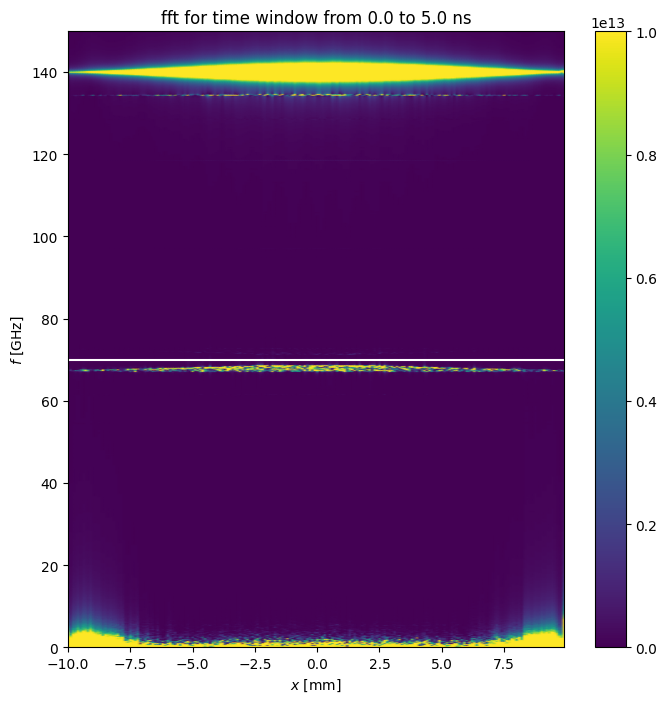

In [31]:
plt.figure(figsize=(8, 8))
plt.pcolormesh(x_full[where_x]*1e3, freq[where_freq]*1e-9, np.abs(E_spec[where_freq])**2, shading='gouraud', cmap='viridis', vmin=0, vmax=10e12)
plt.plot(x_full[where_x]*1e3, np.ones_like(x_full[where_x])*f0/2*1e-9, 'w-')
plt.xlabel(r'$x$ [mm]')
plt.ylabel(r'$f$ [GHz]')
plt.title('fft for time window from ' + str(round(tmin*1e9, 0)) + ' to ' + str(round(tmax*1e9, 0)) + ' ns')
# plt.ylim(65, 75)
plt.colorbar()
plt.show()

In [32]:
tmin, tmax = 5e-9, 10e-9
xmin, xmax = np.min(x_full), np.max(x_full)
where_t = np.where((t_full >= tmin) & (t_full <= tmax))
_where_x = np.where((x_full >= xmin) & (x_full <= xmax))
where_x = _where_x[0][np.arange(0, len(x_full[_where_x]), int(len(x_full[_where_x])/100))]
E_spec = fft_without_mean(E_full[where_t][:, where_x].squeeze(), axis=0)
freq = fftfreq(t_full[where_t].shape[-1], d = t_full[where_t][1] - t_full[where_t][0])
where_freq = np.where((freq >= 0) & (freq <= 150e9))

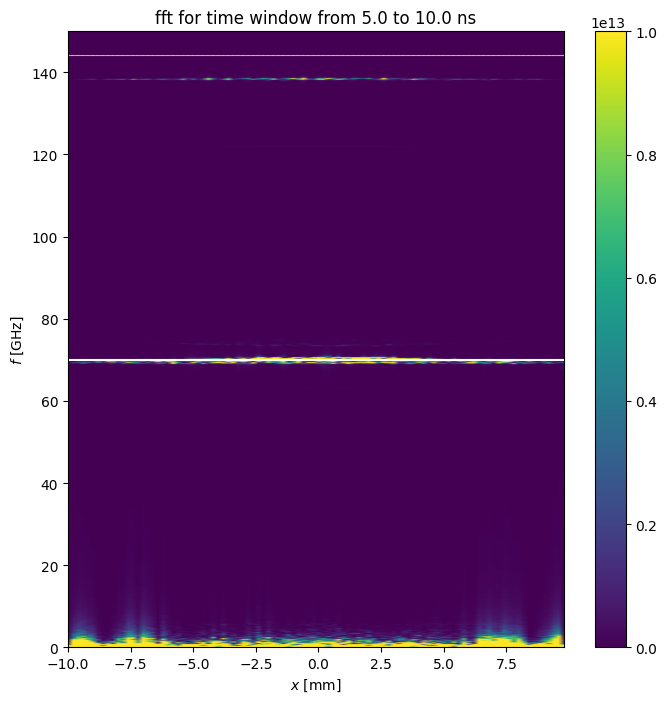

In [33]:
plt.figure(figsize=(8, 8))
plt.pcolormesh(x_full[where_x]*1e3, freq[where_freq]*1e-9, np.abs(E_spec[where_freq])**2, shading='gouraud', cmap='viridis', vmin=0, vmax=10e12)
plt.plot(x_full[where_x]*1e3, np.ones_like(x_full[where_x])*f0/2*1e-9, 'w-')
plt.xlabel(r'$x$ [mm]')
plt.ylabel(r'$f$ [GHz]')
plt.title('fft for time window from ' + str(round(tmin*1e9, 0)) + ' to ' + str(round(tmax*1e9, 0)) + ' ns')
# plt.ylim(65, 75)
plt.colorbar()
plt.show()

In [25]:
tmin, tmax = 15e-9, 38e-9
xmin, xmax = np.min(x_full), np.max(x_full)
where_t = np.where((t_full >= tmin) & (t_full <= tmax))
_where_x = np.where((x_full >= xmin) & (x_full <= xmax))
where_x = _where_x[0][np.arange(0, len(x_full[_where_x]), int(len(x_full[_where_x])/100))]
E_spec = fft_without_mean(E_full[where_t][:, where_x].squeeze(), axis=0)
freq = fftfreq(t_full[where_t].shape[-1], d = t_full[where_t][1] - t_full[where_t][0])
where_freq = np.where((freq >= 0) & (freq <= 150e9))

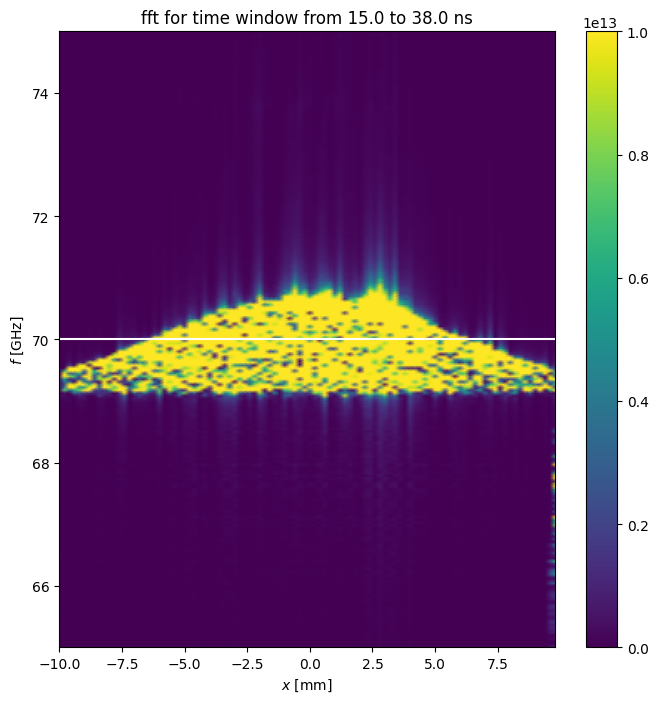

In [26]:
plt.figure(figsize=(8, 8))
plt.pcolormesh(x_full[where_x]*1e3, freq[where_freq]*1e-9, np.abs(E_spec[where_freq])**2, shading='gouraud', cmap='viridis', vmin=0, vmax=10e12)
plt.plot(x_full[where_x]*1e3, np.ones_like(x_full[where_x])*f0/2*1e-9, 'w-')
plt.xlabel(r'$x$ [mm]')
plt.ylabel(r'$f$ [GHz]')
plt.title('fft for time window from ' + str(round(tmin*1e9, 0)) + ' to ' + str(round(tmax*1e9, 0)) + ' ns')
plt.ylim(65, 75)
plt.colorbar()
plt.show()

In [27]:
np.ones_like(x_full[where_x])*f0/2*1e-9

array([70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
       70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
       70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
       70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
       70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
       70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
       70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
       70., 70., 70., 70., 70., 70., 70., 70., 70.])

In [28]:
E_full[where_t, :].shape

(1, 33166, 1600)

In [ ]:
from scipy.signal import stft
nperseg = int(E_full[where_t].shape[0]/2)
noverlap = int(nperseg / 2)
print('nperseg', nperseg)
print('noverlap', noverlap)
# spatial_freq_epoch, xs_epoch, Zxx = stft(E_full[where_t], 1/np.diff(x_full[:2])[0], nperseg=nperseg, noverlap=noverlap)
# ks_epoch = 2*np.pi*spatial_freq_epoch

# fig = plt.figure()
# plt.pcolormesh(xs_epoch*1e3, ks_epoch*1e-3, np.abs(Zxx)**2*1e-12, shading='gouraud')
# plt.plot(xs_orig[i_start_orig:i_end_orig]*1e3, ks_orig[i_start_orig:i_end_orig]*1e-3, color='w', label=r'$\mathbf{z}(\tau) \; (T_e = 300$ eV)')
# plt.xlim(epoch_data['x'][0]*1e3, epoch_data['x'][0]*1e3 + np.max(xs_epoch)*1e3)
# plt.xlim(7, epoch_data['x'][0]*1e3 + np.max(xs_epoch)*1e3)
# plt.ylabel(r'$k \,\, [\mathrm{mm^{-1}}]$')
# plt.xlabel(r'$x \, [\mathrm{mm}]$')
# plt.xlim(11, 12.5)
# plt.ylim(0, 50)
# cbar = plt.colorbar()
# cbar.set_label(r'$\left| \mathrm{FT} \left \{ E_x \right \} \right|^2$ [$\, \mathrm{{MV}^2/m^2}$]', size=11)
# plt.legend(labelcolor='white', fontsize=10, facecolor='none')
# plt.savefig('./plots/XB_epoch_stft.png', dpi=300)
# plt.show()

In [ ]:
1/np.diff(x_full[:2])[0]

In [ ]:
spatial_freq_epoch, xs_epoch, Zxx = stft(E_full[where_t], 1/np.diff(x_full[:2])[0], nperseg=nperseg, noverlap=noverlap)

In [ ]:
nperseg, noverlap

In [ ]:
xs_epoch, ks_epoch

In [ ]:
f0 = f0
omega0 = 2*np.pi*f0
x0 = 0e-3
k0 = get_k0(x0, omega0, 0, 50000)
# print('k0', k0, ' m^-1')

In [ ]:
k0 = get_k0(x0, omega0, 0, 10000)

In [ ]:
ki = np.linspace(0, 20e3, 1000)
omegai = 2*np.pi*np.linspace(1e-6, 300e9, 1000)
K, O = np.meshgrid(ki, omegai, indexing='ij')

plt.figure(figsize=(7, 5))
plt.contour(K * 1e-3, O/(2*np.pi) * 1e-9, D_vec(x0*np.ones_like(K), K, O), levels=[0], colors=['k'])
plt.plot(k0*1e-3, f0 * 1e-9, 'ro')
plt.ylabel(r'$f$ [GHz]')
plt.xlabel(r'$k \, \mathrm{\left[ mm^{-1} \right]}$')
plt.plot(ki * 1e-3, f0*np.ones_like(ki) * 1e-9, 'r-')
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
k0